In [1]:
#
# From https://minerl.io/docs/environments/index.html#id9
#
import gym
from gym import spaces
import minerl
import logging
import numpy as np
import collections
import torch
from itertools import chain

C:\Users\X\anaconda3\envs\myenv\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [2]:
device = torch.device("cuda:0")

In [7]:
env = gym.make("MineRLNavigateDense-v0") # A MineRLNavigateDense-v0 env

In [8]:
# Run a random agent through the environment
def train(env, agent, config):
    
    num_episodes = config["NUM_EPISODES"]
    episodic_rewards = [0] * num_episodes
    episodic_moves = [0] * num_episodes
    
    for episode in range(num_episodes):
        obs = env.reset()
        done = False
        net_reward = 0
        steps = 0
        
        obs["pov"] = obs["pov"].reshape(3,64,64)
        obs["pov"] = torch.from_numpy(obs["pov"]).float().to(device).unsqueeze(0)
        obs["compassAngle"] = torch.from_numpy(obs["compassAngle"]).float().to(device).unsqueeze(0)
                                      
        while not done:
            # this is only outputting the camera controls
            camera_action = agent.step(obs)
    
            env_action = {}
            
            env_action["camera"] = [0, camera_action.detach().cpu().item()]
            env_action["attack"] = 0
            env_action["back"] = 0
            env_action["forward"] = 1
            env_action["jump"] = 1
            env_action["left"] = 0
            env_action["place"] = "none"
            env_action["right"] = 0
            env_action["sneak"] = 0
            env_action["sprint"] = 0
    
            steps = steps + 1
            next_obs, reward, done, info = env.step(env_action)
            
            next_obs["pov"] = next_obs["pov"].reshape(3,64,64)
            next_obs["pov"] = torch.from_numpy(next_obs["pov"]).float().to(device).unsqueeze(0)
            next_obs["compassAngle"] = torch.from_numpy(next_obs["compassAngle"]).float().to(device).unsqueeze(0)
    
            camera_action = camera_action.unsqueeze(0)
            reward = torch.tensor([reward], device=device)
            done = torch.tensor([done], device=device).int()
            
            
            agent.memory.store_transition(obs, camera_action, next_obs, reward, done)
            #print("Step Reward:", reward)
            agent.evaluate()
            obs = next_obs     
            episodic_rewards[episode] += reward
            episodic_moves[episode] += 1
    
        #print(episode)
        print("Episode Reward:", episodic_rewards[episode])
        agent.alpha = np.clip(agent.alpha * config["DECAY_ALPHA"], 0.01, .99)
    return episodic_rewards, episodic_moves        
     
    # Do something

In [14]:
%run SoftAC.ipynb
agent_config = {
    "ALPHA": .5,
    "GAMMA": .99,
    "POLYAK": .99,
    "LEARNING_RATE": .00001,
    "MAX_MEMORY": 50000,
    "BATCH_SIZE": 24
}
agent = SoftACAgent(env, agent_config)

In [15]:
train_config = {
    "NUM_EPISODES": 25,
    "DECAY_ALPHA": .9
}
rew, moves = train(env, agent, train_config)

Episode Reward: tensor([150.9814], device='cuda:0')
Episode Reward: tensor([-18.1095], device='cuda:0')
Episode Reward: tensor([-33.0356], device='cuda:0')
Episode Reward: tensor([-60.5006], device='cuda:0')
Episode Reward: tensor([148.4782], device='cuda:0')
Episode Reward: tensor([8.9707], device='cuda:0')
Episode Reward: tensor([2.4359], device='cuda:0')
Episode Reward: tensor([-109.4196], device='cuda:0')
Episode Reward: tensor([-8.6251], device='cuda:0')
Episode Reward: tensor([-133.9125], device='cuda:0')
Episode Reward: tensor([-131.4520], device='cuda:0')
Episode Reward: tensor([-41.1256], device='cuda:0')
Episode Reward: tensor([-205.0617], device='cuda:0')
Episode Reward: tensor([-94.6793], device='cuda:0')
Episode Reward: tensor([-295.4814], device='cuda:0')
Episode Reward: tensor([-233.5672], device='cuda:0')
Episode Reward: tensor([-45.5719], device='cuda:0')
Episode Reward: tensor([-156.7857], device='cuda:0')
Episode Reward: tensor([-173.3141], device='cuda:0')
Episode R

In [27]:
env.close()

Failed to delete the temporary minecraft directory.


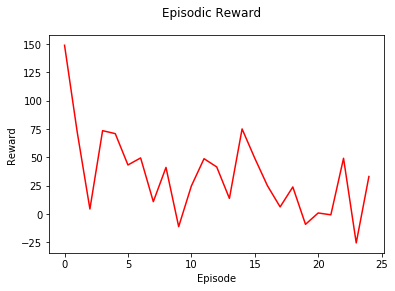

In [24]:
import matplotlib.pyplot as plt
plt.plot(rew, 'r')
plt.suptitle('Episodic Reward')
plt.ylabel('Reward')
plt.xlabel('Episode')
plt.show()

In [11]:
sum(rew)/len(rew)

tensor([-10.9511], device='cuda:0')

In [12]:
max(rew)

tensor([64.6927], device='cuda:0')

In [13]:
moves[0]

6000

In [18]:
torch.save(agent.critic1.state_dict(), 'c1.pt')
torch.save(agent.critic2.state_dict(), 'c2.pt')
torch.save(agent.actor.state_dict(), 'a.pt')

In [20]:
from numpy import save
save('rew.npy', rew)
save('moves.npy', moves)

In [21]:
def perform(env, agent):
    obs = env.reset()
    done = False
    rews = []
    obs["compassAngle"] = torch.from_numpy(obs["compassAngle"]).float().to(device).unsqueeze(0)
    while not done:
        camera_action = agent.step(obs, True)
        env_action = {}
            
        env_action["camera"] = [0, camera_action.detach().cpu().item()]
        env_action["attack"] = 0
        env_action["back"] = 0
        env_action["forward"] = 1
        env_action["jump"] = 1
        env_action["left"] = 0
        env_action["place"] = "none"
        env_action["right"] = 0
        env_action["sneak"] = 0
        env_action["sprint"] = 0
        
        obs, reward, done, info = env.step(env_action)
        env.render()
        rews.append(reward)
        obs["compassAngle"] = torch.from_numpy(obs["compassAngle"]).float().to(device).unsqueeze(0)
    plt.plot(rews)
    plt.show()

In [ ]:
#%run SoftAC.ipynb
#agent = SoftACAgent(env, agent_config)
#agent.critic1.load_state_dict(torch.load('c1.pt'))
#agent.critic2.load_state_dict(torch.load('c2.pt'))
#agent.actor.load_state_dict(torch.load('a.pt'))

In [28]:
perform(env,agent)

AttributeError: 'NoneType' object has no attribute 'sendall'